 - 학교: 우송대학교     
 - 학번: e202111352       
 - 성명: 이예원

# **시계열 데이터 활용**
## **ECG**
    - 심전도는 심장의 전기적 활동을 측정한 데이터로 ECG 또는 EKG라고도 함
    - 심장의 전기적 신호에 의해 수축하고 이완되는 신호를 측정
    - 심박수, 심장의 건강상태, 부정맥 등을 판단

- ECG의 구성 요소
     - 파(wave): 심장이 수축하기 전의 전기적 신호
         - P wave: 심장이 수축하기 전의 전기적 신호
         - QRS complex: 짧은 시간에 급격히 이루어짐, 심장의 실질적인 수축을 나타내는 신호
         - Q wave, R wave, S wave는 매우 빠른 속도로 발생하므로 하나의 complex로 표현
     - 구간(interval): 파들 사이의 시간 간격
         - PR interval: P wave와 QRS complex 사이의 시간
         - QT interval: QRS complex와 T wave 사이의 시간
     - 분절(segment): 파 또는 구간의 일부분
         - PR segment: P wave와 QRS complex 사이의 시간
         - ST segment: S wave와 T wave 사이의 시간

### ECG 데이터 수집

#### NeuroKit2 라이브러리 ECG 신호
 - PhysioNet 데이터셋을 이용하여 분석할 수도 있으나, 데이터셋을 이해하고 데이터 형식에 맞추어 변환하는 작업이 생각보다 쉽지 않음
      - Neurokit2 라이브러리를 사용하여 예제 데이터 또는 가상의 ECG 데이터 생성 가능
 - ecg_simulate() 함수를 사용하여 가상의 ECG numpy array 데이터 생성
      - duration: 데이터의 길이(초)
      - length: 데이터의 길이(샘플 수)
      - sampling_rate: 샘플링 주파수
      - heart_rate: 심박수(bpm)
      - heart_rate_std: 심박수의 표준편차
      - noise: 노이즈의 크기
      - method: ECG 생성 방법
           - simple: 단순한 ECG 신호 생성
           - ecgsyn: 실제 ECG 신호와 유사한 신호 생성(디폴트)
           - multiLeads: 12개 리드의 ECG 신호 생성
      - random_state: 난수 생성 시드

In [44]:
import neurokit2 as nk
import numpy as np

ecg_simulate = nk.ecg_simulate(
    duration=10,        # 10초간 데이터 생성
    heart_rate=70,    
    noise=0.1,          # 노이즈 정도
    random_state=42     # 재현성을 위한 시드값
)

type(ecg_simulate)

numpy.ndarray

#### ECG 신호 시각화
 - signal_plot() ECG 신호를 그래프로 표시
     - signal: array 또는 DataFrame
     - subplots: 서브플롯 사용 여부
     - labels: 서브그래프 레이블

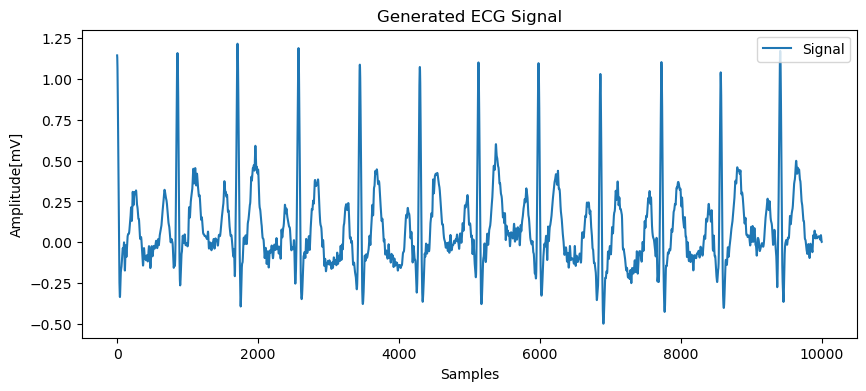

In [45]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 4]

nk.signal_plot(ecg_simulate)

plt.title("Generated ECG Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude[mV]")
plt.show()

### ECG 전처리
 - ECG 데이터는 심전도의 전기적 신호를 측정한 것으로, 전처리 과정이 필요
     - 노이즈 제거(ecg_clean()): 신호에 포함된 노이즈 제거
     - R-peak 검출(ecg_peaks() ): R-peak을 검출
     - R-R 간격 계산(ecg_rate()): R-R 간격을 계산하여 심박수 추정
     - 신호 품질 평가(ecg_quality()): ECG 신호의 품질을 평가

#### 노이즈 제거
 - ecg_clean() 함수를 사용하여 ECG 신호의 노이즈 제거
     - ecg_signal : ECG 신호
     - sampling_rate: ECG 신호의 샘플링 주파수
     - method: 노이즈 제거 방법
         - neurokit : 0.5Hz 고역 통과 버터워스 필터(차수 = 5)(디폴트)
         - biosppy, pantompkins1985 등 다양한 필터가 있음

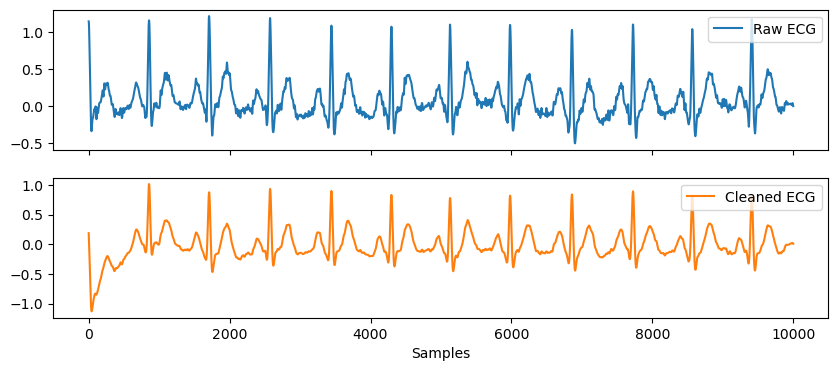

In [46]:
ecg_cleaned = nk.ecg_clean(
    ecg_simulate,
    sampling_rate=1000,     # 샘플링 주파수
    method="neurokit"
)

nk.signal_plot(
    [ecg_simulate, ecg_cleaned],        # 원본, 정제된 신호
    labels=["Raw ECG", "Cleaned ECG"],
    subplots=True
)

In [47]:
# 정제된 이후의 신호는 위처럼 시작 부분에 왜곡이 발생하므로 시작 부분 제거
ecg_cleaned = ecg_cleaned[1000:]

#### R peak 검출
 - ecg_peaks() 함수를 사용하여 ECG 신호에서 R peak을 검출
     - ecg_signal: ECG 신호
     - sampling_rate: ECG 신호의 샘플링 주파수
     - method: R peak 검출 방법
         - neurokit: QRS 복합체에서 국소적 최대값으로 감지(디폴트)
         - hamilton2002, pantompkins1985 등 다양한 알고리즘이 있음
     - correct_artifacts: 잘못된 R peak을 수정
     - show: R peak을 표시

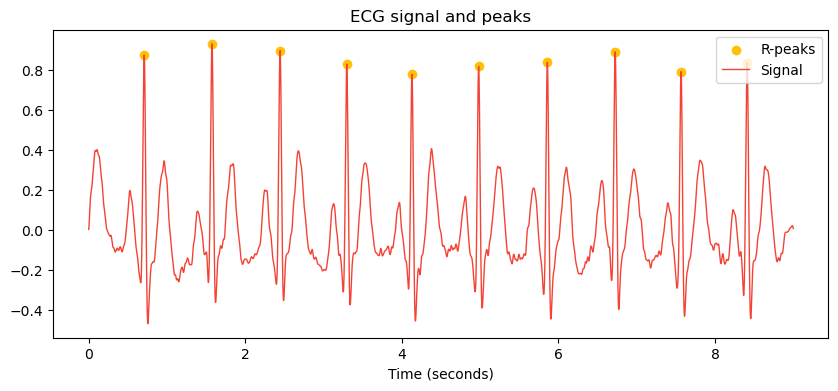

In [48]:
rpeaks_instances, rpeaks_info = nk.ecg_peaks(
    ecg_cleaned,            # 신호 데이터
    sampling_rate=1000,     # 샘플링 주파수
    correct_artifacts=True, # 아티팩트(왜곡이 있는 부분) 수정
    show=True               # 플롯 출력
)

In [49]:
rpeaks_instances

,ECG_R_Peaks
0,0
1,0
2,0
3,0
4,0
...,...
8995,0
8996,0
8997,0
8998,0


In [50]:
# 변경된 신호 데이터 축에서 R-peak만 추출
rpeaks_instances[rpeaks_instances["ECG_R_Peaks"]!=0]

,ECG_R_Peaks
709,1
1575,1
2445,1
3296,1
4129,1
4981,1
5858,1
6725,1
7566,1
8410,1


In [51]:
rpeaks_info

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([ 709, 1575, 2445, 3296, 4129, 4981, 5858, 6725, 7566, 8410]),
 'ECG_R_Peaks_Uncorrected': array([ 709, 1575, 2445, 3296, 4129, 4981, 5858, 6725, 7566, 8410]),
 'ECG_fixpeaks_ectopic': [],
 'ECG_fixpeaks_missed': [],
 'ECG_fixpeaks_extra': [],
 'ECG_fixpeaks_longshort': [],
 'ECG_fixpeaks_method': 'kubios',
 'ECG_fixpeaks_rr': array([0.85566667, 0.866     , 0.87      , 0.851     , 0.833     ,
        0.852     , 0.877     , 0.867     , 0.841     , 0.844     ]),
 'ECG_fixpeaks_drrs': array([-0.03693152,  0.29439696,  0.11396011, -0.54131054, -0.51282051,
         0.54131054,  0.71225071, -0.28490028, -0.74074074,  0.08547009]),
 'ECG_fixpeaks_mrrs': array([ 0.06662629,  0.37552998,  0.33313144, -0.33918837, -1.5142338 ,
        -0.13325257,  0.90854028,  0.56329497, -0.72683222, -0.29073289]),
 'ECG_fixpeaks_s12': array([ 0.29439696,  0.11396011,  0.29439696, -0.51282051, -0.54131054,
         0.71225071,  0.

#### 파형 검출
 - ecg_delineate() 함수를 사용하여 ECG 신호의 파형을 검출(PQRS의 위치를 찾는 것)
     - ecg_clean: 노이즈 제거된 ECG 신호
     - rpeaks: R peak의 위치
     - sampling_rate: ECG 신호의 샘플링 주파수
     - method: 파형 검출 방법
         - peak : 피크 기반 파형 검출(디폴트)
         - prominence, dwt 등 다양한 알고리즘이 있음
     - show: 파형을 표시
     - show_type: 표시할 파형의 종류
         - all: 데이터의 모든 파형 표시
         - peaks : 모든 피크를 표시
         - bounds_R, bounds_T, bounds_P: R, T, P 파형만 표시

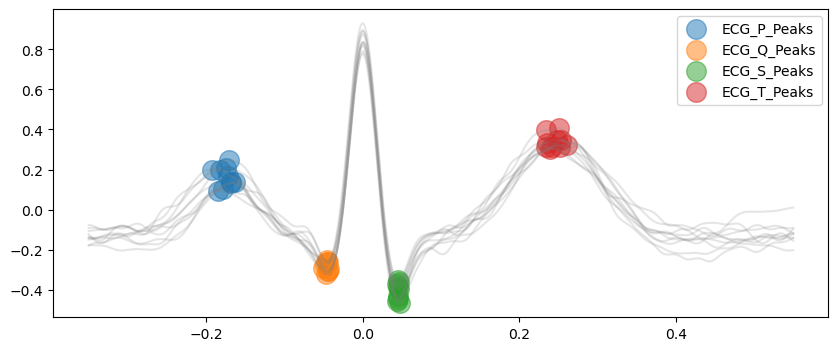

In [52]:
waves_data, waves = nk.ecg_delineate(
    ecg_cleaned,
    rpeaks=rpeaks_info,     # R-peaks 위치
    sampling_rate=1000,
    show=True,
    show_type="peaks"       #모든 피크를 표시
)

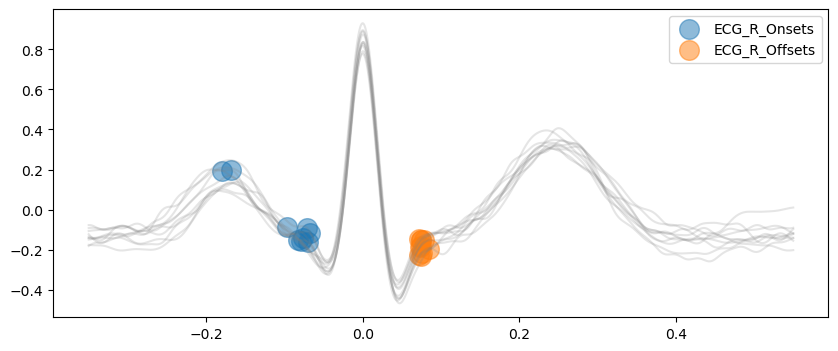

In [53]:
waves_data, waves = nk.ecg_delineate(
    ecg_cleaned,
    rpeaks=rpeaks_info,    
    sampling_rate=1000,
    show=True,
    show_type="bounds_R" 
)

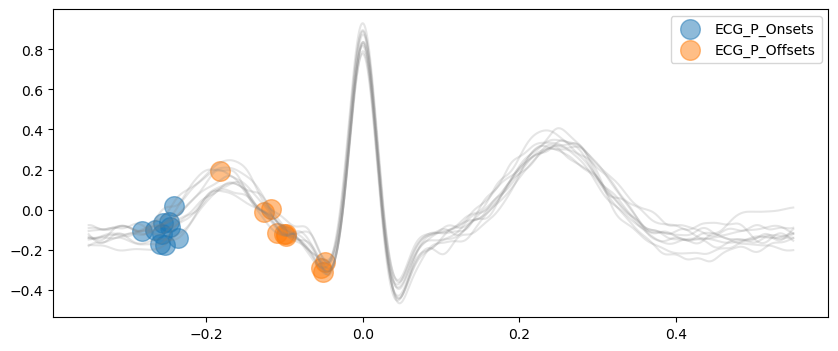

In [54]:
waves_data, waves = nk.ecg_delineate(
    ecg_cleaned,
    rpeaks=rpeaks_info, 
    sampling_rate=1000,
    show=True,
    show_type="bounds_P"
)

In [55]:
# 각 파형의 피크, 시작, 끝의 위치
waves_data.head()

,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [56]:
waves

{'ECG_P_Peaks': [526, 1390, 2252, 3127, 3966, 4809, 5683, 6554, 7397, 8232],
 'ECG_P_Onsets': [462, 1316, 2190, 3043, 3883, 4716, 5617, 6443, 7309, 8174],
 'ECG_P_Offsets': [661, 1477, 2263, 3195, 4003, 4871, 5807, 6607, 7513, 8312],
 'ECG_Q_Peaks': [np.int64(664),
  np.int64(1529),
  np.int64(2397),
  np.int64(3251),
  np.int64(4085),
  np.int64(4936),
  np.int64(5811),
  np.int64(6679),
  np.int64(7515),
  nan],
 'ECG_R_Onsets': [529, 1507, 2277, 3219, 4059, 4898, 5779, 6654, 7469, nan],
 'ECG_R_Offsets': [793, 1649, 2516, 3370, 4204, 5059, 5932, 6799, 7638, 8483],
 'ECG_S_Peaks': [np.int64(756),
  np.int64(1621),
  np.int64(2490),
  np.int64(3340),
  np.int64(4173),
  np.int64(5026),
  np.int64(5903),
  np.int64(6771),
  np.int64(7611),
  nan],
 'ECG_T_Peaks': [962, 1835, 2678, 3531, 4379, 5233, 6099, 6964, 7814, 8644],
 'ECG_T_Onsets': [942, 1782, 2631, 3424, 4273, 5136, 6002, 6846, 7683, 8575],
 'ECG_T_Offsets': [1093, 1912, 2813, 3649, 4484, 5240, 6249, 7045, 7910, 8656]}

#### 심박수 계산
 - 신호 속도(heart rate)는 1분 동안 발생하는 R peak의 수로 계산
 - signal_rate()
     - peaks : R peak의 위치
     - sampling_rate: 샘플링 주파수
     - desired_length: 계산할 심박수의 길이 
      - method: R peaks 사이의 값을 보간하는 방법
         - monotone_cubic: 단조 큐빅 보간법(디폴트)
     - show: 심박수 추이를 시각화

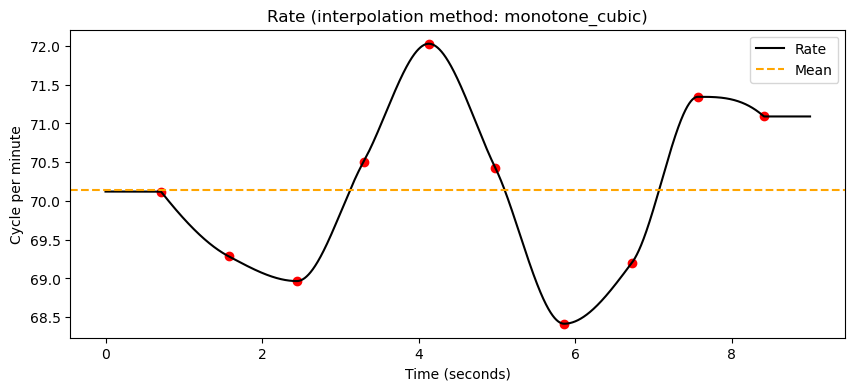

In [57]:
rate = nk.signal_rate(
    peaks=rpeaks_info["ECG_R_Peaks"],       # R-peaks 위치
    sampling_rate=1000,
    desired_length=len(ecg_cleaned),        # 신호 길이
    interpolation_method="monotone_cubic",  # 보간 방법
    show=True   
)

#### ECG 신호 품질 평가
 - ecg_quality() 함수를 사용하여 ECG 신호의 품질을 평가
     - ecg_cleaned: 정제된 ECG 신호
     - rpeaks: R peak의 위치
     - sampling_rate: 샘플링 주파수
     - method: ECG 신호의 품질 평가 방법
         - averageQRS: 평균 QRS 세그먼트에서 각 QRS 세그먼트의 거리를 보간하여 연속 지수를 계산(디폴트)
             - 연속 지수가 1에 가까울수록 신호가 평균에 가까움
         - zhao2018: Zhao et al. (2018)의 방법

In [58]:
# ECG 품질 지수 계산
quality = nk.ecg_quality(
    ecg_cleaned,
    rpeaks=rpeaks_info["ECG_R_Peaks"],
    sampling_rate=1000,
    method='averageQRS'        # 품질 지수 계산 방법
)

quality

array([0.02861104, 0.02861104, 0.02861104, ..., 0.        , 0.        ,
       0.        ])

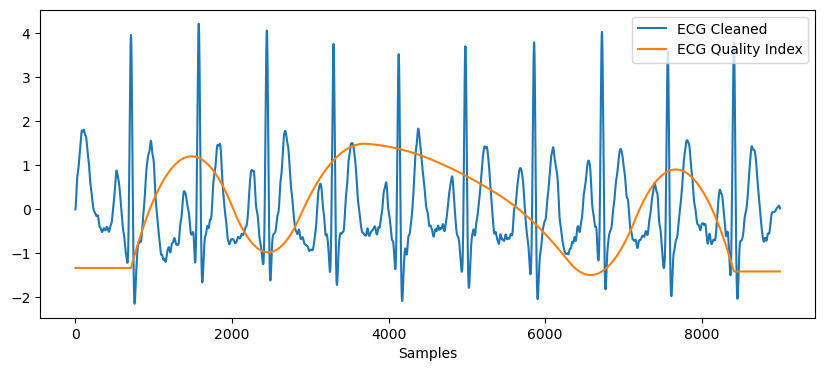

In [59]:
# 품질 지수 플롯
nk.signal_plot(
    [ecg_cleaned, quality],
    labels=["ECG Cleaned", "ECG Quality Index"],
    standardize=True
)

#### 전처리 파이프라인
 - 파이프라인은 전처리 과정을 파이프라인으로 구성하여 한 번에 처리
 - 노이즈 제거, R peak 검출, 심박수 계산 등을 순차적으로 처리
#### 자동화된 ECG 전처리
 -  ecg_process()
     - ecg_signal: ECG 신호
     - sampling_rate: 샘플링 주파수
     - method: 전처리 방법
         - neurokit : 노이즈 제거, R peak 검출, 심박수 계산을 순차적으로 처리(디폴트)
         - hamilton2002, pantompkins1985 등 다양한 알고리즘이 있음

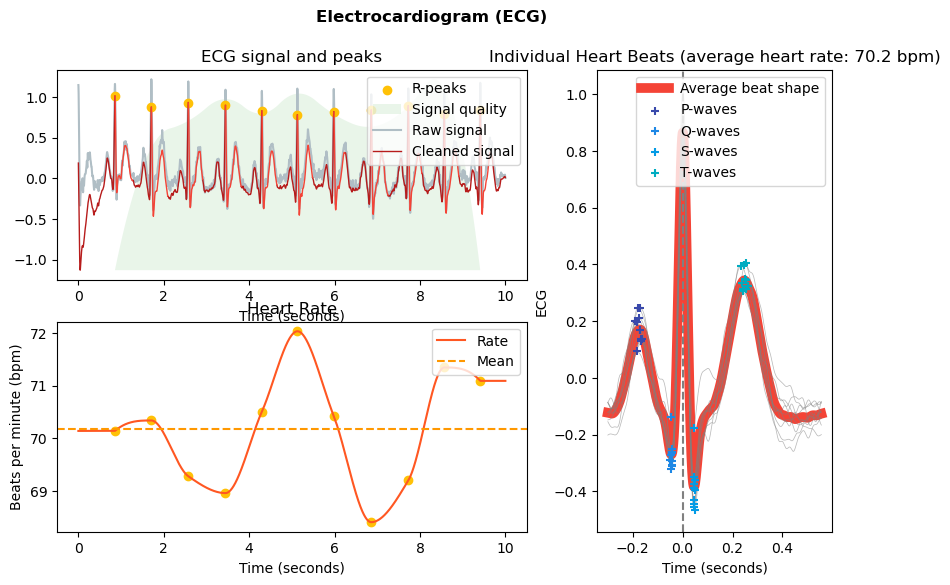

In [60]:
# 전처리 파이프라인을 통한 ECG 데이터 처리
ecg_signals, info = nk.ecg_process(
    ecg_simulate,
    sampling_rate=1000,
    method="neurokit"
)

# 크기 설정
plt.rcParams['figure.figsize'] = [10, 6]

# 통합된 ECG 데이터 플롯
nk.ecg_plot(ecg_signals, info);

In [61]:
ecg_signals

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,1.144713,0.185982,70.142623,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,1.140385,0.154798,70.142623,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,1.130545,0.123352,70.142623,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,1.115027,0.091415,70.142623,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,1.093818,0.058787,70.142623,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.014362,0.014388,71.090047,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
9996,0.009472,0.012758,71.090047,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
9997,0.005616,0.011069,71.090047,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
9998,0.003197,0.009346,71.090047,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


In [62]:
info

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([ 856, 1709, 2575, 3445, 4296, 5129, 5981, 6858, 7725, 8566, 9410]),
 'ECG_R_Peaks_Uncorrected': array([ 856, 1709, 2575, 3445, 4296, 5129, 5981, 6858, 7725, 8566, 9410]),
 'ECG_fixpeaks_ectopic': [],
 'ECG_fixpeaks_missed': [],
 'ECG_fixpeaks_extra': [],
 'ECG_fixpeaks_longshort': [],
 'ECG_fixpeaks_method': 'kubios',
 'ECG_fixpeaks_rr': array([0.8554, 0.853 , 0.866 , 0.87  , 0.851 , 0.833 , 0.852 , 0.877 ,
        0.867 , 0.841 , 0.844 ]),
 'ECG_fixpeaks_drrs': array([-0.02828784, -0.05955335,  0.32258065,  0.09925558, -0.47146402,
        -0.44665012,  0.47146402,  0.62034739, -0.24813896, -0.64516129,
         0.07444169]),
 'ECG_fixpeaks_mrrs': array([ 0.03308519,  0.        ,  0.32533774,  0.40253653, -0.17645437,
        -1.10283981, -0.027571  ,  0.68927488,  0.42735043, -0.55141991,
        -0.22056796]),
 'ECG_fixpeaks_s12': array([-0.05955335, -0.02828784,  0.09925558,  0.32258065, -0.44665012,
  

#### 나만의 전처리 파이프라인 구성

In [67]:
import pandas as pd

# 전처리 파이프라인 함수 정의
def ecg_process_ha(ecg_signal):
    # 노이즈 제거
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=1000, method='neurokit')[1000:]
    rpeaks_instances, rpeaks_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
    rate = nk.ecg_rate(rpeaks_info["ECG_R_Peaks"], sampling_rate=1000, desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, rpeaks=rpeaks_info["ECG_R_Peaks"], sampling_rate=1000)
    # 출력할 데이터프레임 생성
    signals = pd.DataFrame({
        "ECG_Raw": ecg_signal[1000:],
        "ECG_Clean": ecg_cleaned,
        "ECG_Rate": rate,
        "ECG_Quality": quality
    })

    signals = pd.concat([signals, rpeaks_instances], axis=1)

    info = rpeaks_info
    info["sampling_rate"] = 1000

    return signals, info

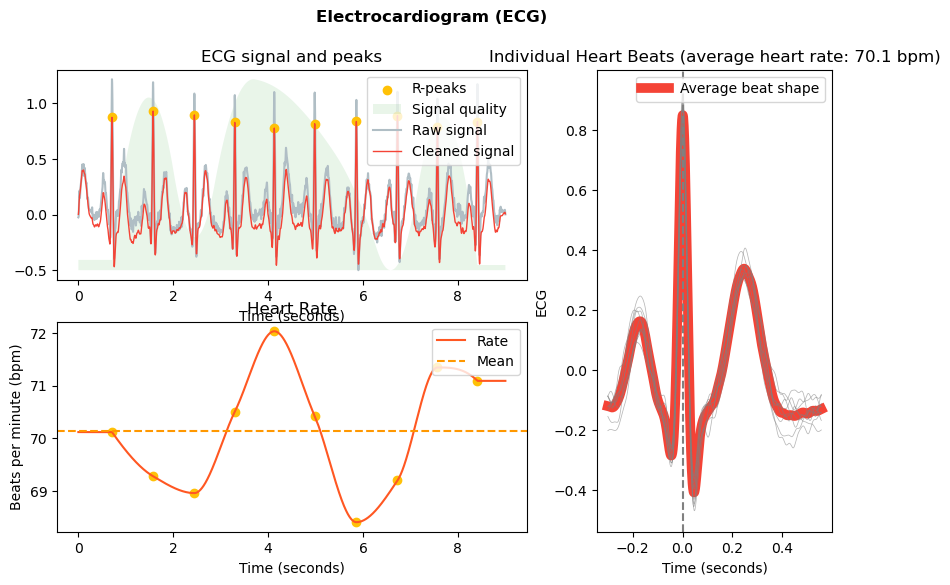

In [68]:
# ECG 전처리 수행
signals, info = ecg_process_ha(ecg_simulate)

# ECG 데이터 플롯
nk.ecg_plot(signals, info)

#### ECG 지표의 활용
 - R peak: QRS complex에서 가장 높은 점
     - 심박수, 심장의 건강 상태 등을 판단하는 데 사용
 - RR 간격(RR Interval): 두 개의 R peak 사이의 시간 간격
     - 심박수, 심장의 건강 상태, 부정맥 등을 판단하는 데 사용
 - 심박수(Heart Rate, HR): 1분 동안 발생하는 R peak의 수
     - 심장 기능이 약하거나 운동 부족 등의 이유로 심장이 느리게 작동
     - 심장 기능이 과도하게 활동하거나 스트레스 등의 이유로 심장이 빠르게 작동
 - QT 간격(QT Interval): QRS complex와 T wave 사이의 시간
     - 심장의 전기적인 활동이 정상적인지, 부정맥 등을 판단하는 데 사용

### HRV 분석
 - 자율신경검사(Heart Rate Variability, HRV)는 심장 박동 간의 시간 간격 변동을 검사하는 방법
 - 개인의 스트레스 수준, 신체적 건강, 정서적 상태 등을 평가하는 데 사용되는 중요한 지표
 - HRV는 자율신경계의 두 주요 구성 요소인 교감신경계와 부교감신경계 사이의 균형을 보여줌
     - 높은 HRV는 심장 박동의 변동성이 큰 것이며, 이는 건강한 심 기능, 낮은 스트레스 수준, 높은 적응력을 나타냄
     - 낮은 HRV는 심장 박동의 변동성이 적은 것이며, 이는 심장 질환, 높은 스트레스 수준, 낮은 적응력을 나타냄

#### 시간 영역 분석
     - 시간축에서의 특징을 분석하는 방법
 - Mean HRT: 평균 심박수
     - 서맥(Bradycardia): 50bpm 미만
     - 정상 심박수(Normal): 60~90bpm
     - 빈맥(Tachycardia): 90bpm 이상
 - SDNN(Standard Deviation of NN intervals): NN 간격(RR interval)의 표준편차
     - 큰 SDNN은 심박 변동성이 크다는 것을 의미 >> 건강한 상태
     - 작은 SDNN은 심박 변동성이 작다는 것을 의미 >> 건강하지 못한 상태
 - RMSSD(Root Mean Square of Successive Differences): 연속적인 NN 간격의 제곱 차이의 제곱근
     - 부교감 신경 조절을 나타내는 고 주파수 영역을 평가
     - RMSSD가 클수록 부교감 신경 조절이 잘 되고 있음
 - pNN50(Percentage of NN50): 연속적인 NN 간격이 50ms 이상 차이가 나는 비율
     - pNN50가 높을수록 부교감 신경 조절이 잘 되고 있음

In [70]:
import neurokit2 as nk

# 샘플 데이터
df = nk.data("bio_resting_5min_100hz")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ECG     30000 non-null  float64
 1   PPG     30000 non-null  float64
 2   RSP     30000 non-null  float64
dtypes: float64(3)
memory usage: 703.2 KB


In [71]:
# 데이터 확인
df.head()

,ECG,PPG,RSP
0,0.003766,-0.102539,0.494652
1,-0.017466,-0.103760,0.502483
2,-0.015679,-0.107422,0.511102
3,-0.001598,-0.110855,0.518791
4,0.002483,-0.112610,0.528669


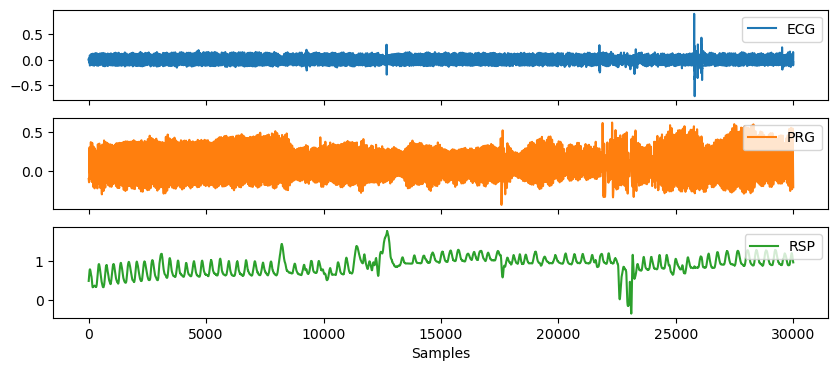

In [72]:
# 데이터 시각화
plt.rcParams['figure.figsize'] = [10, 4]
nk.signal_plot(df, subplots=True, labels=["ECG", "PRG", "RSP"])

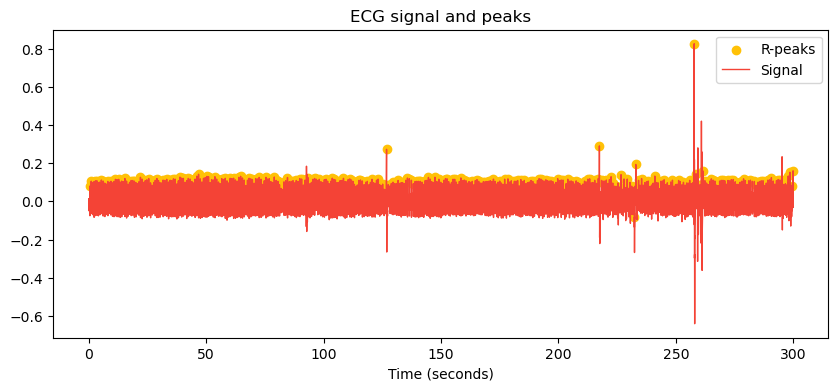

In [74]:
# ECG 데이터만 추출
ecg_signal = df["ECG"]

# 노이즈 제거
ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=100, method="neurokit")

# R-peak 검출
rpeaks_instances, rpeaks_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=100, show=True)

# R-peak 위치 저장
rpeaks = rpeaks_info["ECG_R_Peaks"]

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50
0,696.372093,64.777555,76.484531,15.116279


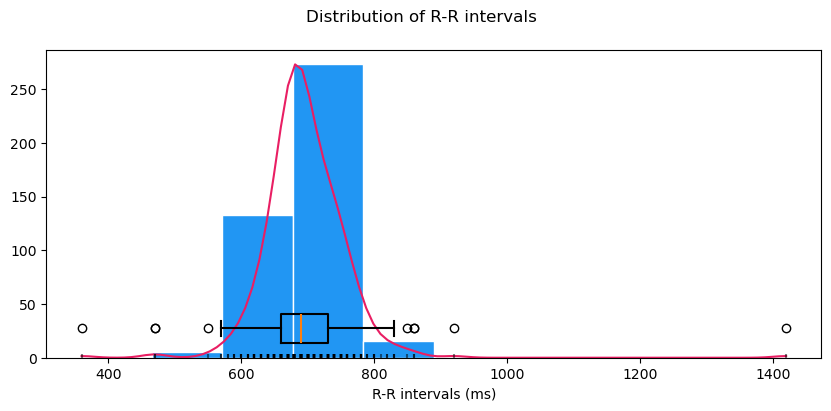

In [75]:
# 시간 영역 분석
hrv_time = nk.hrv_time(rpeaks, sampling_rate=100, show=True)

# 시간 영역 분석 결과
hrv_time[['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_pNN50']]

#### 주파수 영역 분석
     - 시간축을 주파수 영역으로 변환하여 분석하는 방법
 - Total Power: 주파수 대역 전체의 변동성
     - VLF, LF, HF을 포함한 5분 동안의 모든 power를 의미
     - 자율 신경계 조절능력을 반영 Total Power가 클수록 신경계가 잘 조절되고 있음
 - VLF(Very Low Frequency): 0.0033~0.04HZ 주파수 대역
     - 교감신경의 부가적인 정보를 제공 >> VLF가 높을수록 교감신경이 활발하게 작용
 - LF(Low Frequency): 0.04~0.15Hz 주파수 대역
     - 교감신경과 부교감신경의 균형을 나타냄
     - 정신적인 스트레스와 관련이 있으며, LF가 높을수록 스트레스가 높음
 - HF(High Frequency): 0.15~ 0.4Hz 주파수 대역
     - 고주파수 영역이며 호흡 활동과 관련이 있는 성분
 - LF/HF Ratio: LF 주파수 대역과 HF 주파수 대역의 비율
     - 교감신경과 부교감신경의 균형을 나타냄
     - LF/HF Ratio가 높을수록 교감신경이 우세하게 작용
     - LF/HF Ratio가 낮을수록 부교감신경이 우세하게 작용

,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF
0,NaN,0.017393,0.048824,0.064269,0.013135,0.143621,0.759686,0.339952,0.447491,-2.744677


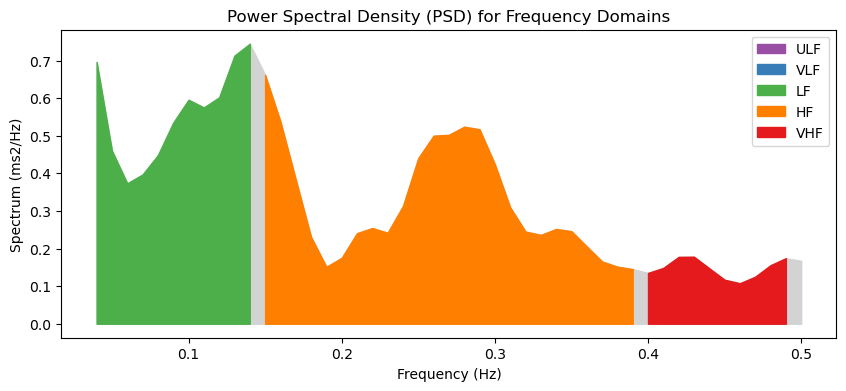

In [76]:
# 주파수 영역 분석
hrv_freq = nk.hrv_frequency(rpeaks, sampling_rate=100, show=True, normalize=True)

hrv_freq

In [77]:
# 주파수 영역 분석 결과
hrv_freq[['HRV_TP', 'HRV_VLF', 'HRV_HF', 'HRV_LFHF']]

,HRV_TP,HRV_VLF,HRV_HF,HRV_LFHF
0,0.143621,0.017393,0.064269,0.759686


#### 비선형 영역 분석
     - 신호의 비선형성을 분석하는 방법
 - SD1: 단기 RR 간격 변동. 즉, 박동 간 변동성의 지수. RMSSD와 동일한 의미
 - SD2: 장기 RR 간격 변동. 즉, 전체 변동성의 지수. SDNN과 동일한 의미
 - SD1/SD2 Ratio: SD1과 SD2의 비율. 교감신경과 부교감신경의 균형을 나타냄



 - 푸엥카레 플롯(Poincare Plot)
     -  푸엥카레 플롯은 연속적인 데이터 간의 관계를 시각화하는 데 사용되는 그래프
         - 이전 시점의 시계열 데이터와 현재 시점의 데이터를 그린 산점도(Scatter plot)
     - 푸엥카레 플롯을 통해 데이터의 불규칙성, 주기성, 규칙성 등을 시각적으로 확인 가능
     - 푸엥카레 플롯의 주요 지표
         - SD1: 음의 상관관계 방향의 표준 편차
             - SD1이 클수록 이전 시점의 데이터와 현재 시점의 데이터가 다름 >> 단기 변동성
         - SD2: 양의 상관관계 방향의 표준 편차
             - SD2가 클수록 이전 시점의 데이터와 현재 시점의 데이터는 변동이 적지만 전체적으로 변동이 큼 장기 변동성
         - SD1/SD2 Ratio: SD1과 SD2의 비율
             - SD1/SD2 Ratio가 1에 가까울수록 단기 변동성과 장기 변동성이 비슷함


,HRV_SD1,HRV_SD2,HRV_SD1SD2
0,54.145713,73.792275,0.733759


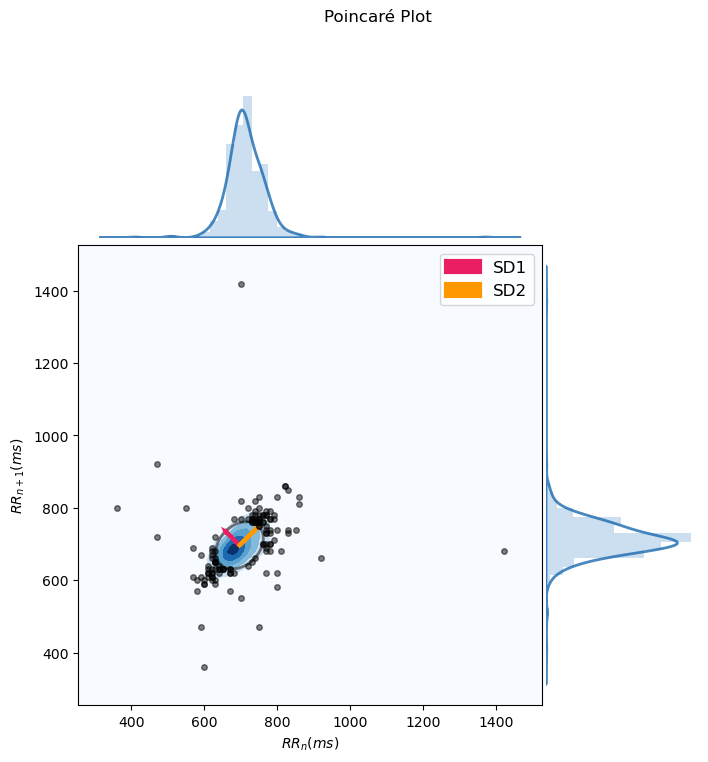

In [ ]:
plt.rcParams['figure.figsize'] = [6, 6]

# 푸엥카레 플롯
hrv_nonlinear = nk.hrv_nonlinear(rpeaks, sampling_rate=100, show=True)

hrv_nonlinear[['HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2']]